In [4]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import glob
import random
import cv2
import numpy as np
from pathlib import Path
import torch

## Criação do Dataset para treinamento

In [ ]:
# Cria/atualiza dataset
dataset_root = "C:/Users/andre/Desktop/Visao/potato_yolov8_1.v1i.yolov8"

yaml_text = f"""
path: {dataset_root}
train: train/images
val: valid/images

names:
  0: healthy
  1: defect
"""

with open("potato.yaml", "w", encoding="utf-8") as f:
    f.write(yaml_text.strip())

print("Arquivo potato.yaml criado/atualizado com path:", dataset_root)


Arquivo potato.yaml criado/atualizado com path: C:/Users/andre/Desktop/Visao/potato_yolov8_1.v1i.yolov8


## Verificação de imagem e máscara

Total imagens (train): 318
Exemplo de 5 imagens (train):
  C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu10_jpg.rf.06544a92036015133e4554714eb7a899.jpg
  C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu10_jpg.rf.33f6f01b75cd480b960d87925d3d0fc3.jpg
  C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu10_jpg.rf.8dd4236a3b5891893afbfe296c2364c8.jpg
  C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu11_jpg.rf.2696d2eb2c636b30c53171cd210c7335.jpg
  C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu11_jpg.rf.b30965ec9736c5652021a4d779efcff4.jpg

Verificando arquivo de exemplo:
Imagem exemplo existe: True
Esperado label em: C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\labels\ghecu1_jpg.rf.01d075867fe657f54190e7698818dd8a.txt
Label existe: True


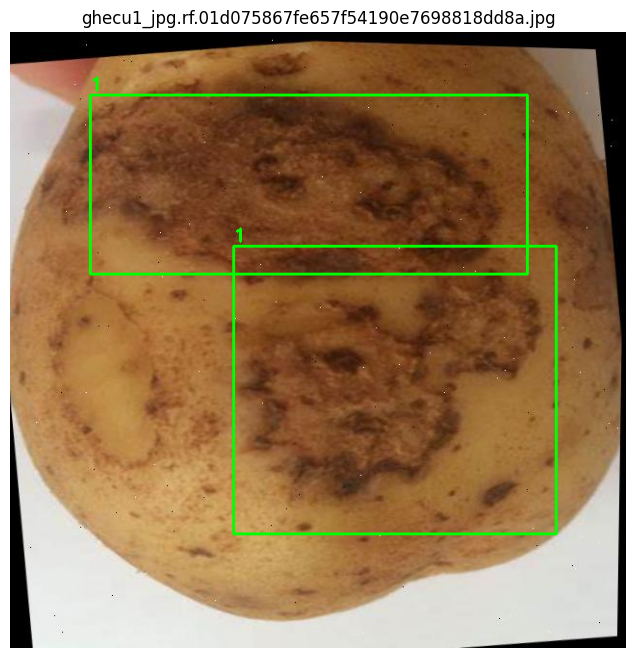

In [ ]:


# Caminho absoluto do seu exemplo (você informou este arquivo)
example_img = r"C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\train\images\ghecu1_jpg.rf.01d075867fe657f54190e7698818dd8a.jpg"

# Diretórios (use o mesmo formato do data.yaml)
dataset_root = r"C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8"
train_images_glob = os.path.join(dataset_root, "train", "images", "*.jpg")
train_labels_dir = os.path.join(dataset_root, "train", "labels")

# listar algumas imagens
imgs = glob.glob(train_images_glob)
print("Total imagens (train):", len(imgs))
if len(imgs) > 0:
    print("Exemplo de 5 imagens (train):")
    for p in imgs[:5]:
        print(" ", p)

# Verificar se o arquivo de exemplo existe
print("\nVerificando arquivo de exemplo:")
print("Imagem exemplo existe:", os.path.isfile(example_img))

# Se existir, procurar o arquivo .txt correspondente
if os.path.isfile(example_img):
    base = os.path.splitext(os.path.basename(example_img))[0]
    label_path = os.path.join(train_labels_dir, base + ".txt")
    print("Esperado label em:", label_path)
    print("Label existe:", os.path.isfile(label_path))

    # Mostrar imagem e, se houver label, desenhar bbox(s)
    img_bgr = cv2.imread(example_img)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # Função utilitária para converter linha YOLO para bbox px
    def yolo_to_bbox(line, img_w, img_h):
        parts = line.strip().split()
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])
        x1 = int((cx - bw/2) * img_w)
        y1 = int((cy - bh/2) * img_h)
        x2 = int((cx + bw/2) * img_w)
        y2 = int((cy + bh/2) * img_h)
        return cls, (x1, y1, x2, y2)

    # desenha bboxes se label existe
    img_disp = img_rgb.copy()
    if os.path.isfile(label_path):
        with open(label_path, 'r') as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
        for ln in lines:
            cls, (x1,y1,x2,y2) = yolo_to_bbox(ln, w, h)
            # desenhar bbox em img_disp (cv2 usa BGR, então convertemos temporariamente)
            tmp = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)
            color = (0,255,0)  # verde (BGR)
            cv2.rectangle(tmp, (x1,y1), (x2,y2), color, 2)
            cv2.putText(tmp, str(cls), (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            img_disp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    else:
        print("Label não encontrada — será exibida apenas a imagem.")

    plt.figure(figsize=(8,8))
    plt.imshow(img_disp)
    plt.axis('off')
    plt.title(os.path.basename(example_img))
    plt.show()
else:
    print("Imagem de exemplo não encontrada. Verifique o caminho.")


## Treinamento do Modelo

In [ ]:
model = YOLO("yolov8n.pt")  # detection model 

model.train(
    data="potato.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    device=0  # GPU
)



Ultralytics 8.3.235  Python-3.10.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=potato.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F75C3905B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

## Carregar e rodar o modelo


image 1/1 C:\Users\andre\Desktop\Visao\potato_yolov8_1.v1i.yolov8\test\images\ghecu33_jpg.rf.2fdd12815282f98ba0584e17de425524.jpg: 640x640 4 healthys, 14.6ms
Speed: 2.2ms preprocess, 14.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


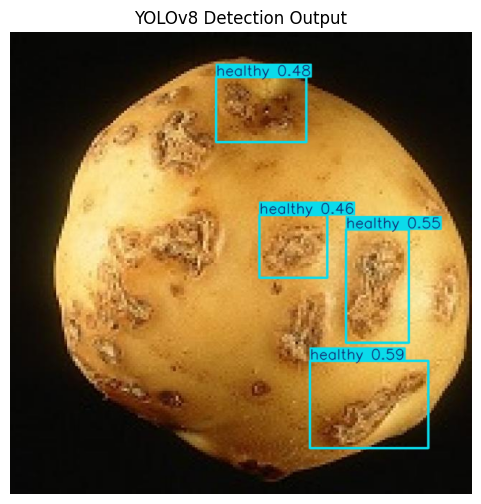

In [ ]:
trained = YOLO("yolo_defeitos/best.pt") # mudar path

test_img = "C:/Users/andre/Desktop/Visao/potato_yolov8_1.v1i.yolov8/test/images/ghecu33_jpg.rf.2fdd12815282f98ba0584e17de425524.jpg"
results = trained(test_img, conf=0.4)
plt.figure(figsize=(6,6))
plt.imshow(results[0].plot()[:, :, ::-1])
plt.title("YOLOv8 Detection Output")
plt.axis("off")
plt.show()
